# Playing with Coronavirus Timeseries

- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset


## Notes

- This notebook uses 2 classes (based on a BaseDataset class) to load in data from both a kaggle dataset (novel coronavirus 2019) and the Covid Tracking Project data

## To Do:

- [x] Add data from Covid Tracking Project's API
    - https://covidtracking.com/api
    
- [ ] Move app styling to a css file in a new `assets/` folder

- Functions and classes are in functions.py

### RESOURCES FOR FUTURE
- RAFAEL STUDY GROUP FOR MAKING A MAP
    - https://www.youtube.com/watch?v=MAhK7NHXEOg&feature=emb_logo
    - https://github.com/erdosn/additional-topic-plotly

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

import cufflinks as cf
cf.go_offline()
cf.set_config_file(sharing='public',theme='solar',offline=True)

In [2]:
import os,glob,sys
import re

!pip install -U fsds
from fsds.imports import *


Bad key "text.kerning_factor" on line 4 in
/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



fsds v0.2.15 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [3]:
import functions as fn

%load_ext autoreload
%autoreload 2

In [4]:
help(fn)

Help on module functions:

NAME
    functions

CLASSES
    builtins.object
        BaselineData
            CoronaData
            CovidTrackingProject
    
    class BaselineData(builtins.object)
     |  #Make a base class
     |  
     |  Methods defined here:
     |  
     |  __repr__(self)
     |      Return repr(self).
     |  
     |  __str__(self)
     |      Return str(self).
     |  
     |  get_group_ts(self, group_name, group_col='state', ts_col=None, df=None, freq='D', agg_func='sum')
     |      Take df_us and extracts state's data as then Freq/Aggregation provided
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
     |  
     |  df
    
    class CoronaData(BaselineData)
     |  Dataset from the Novel Coronavirus Kaggle r

# Main Kaggle Dataset - Get US States

# 📦class `CoronaData`

In [5]:
from functions import BaselineData
from functions import CoronaData
# fs.ihelp(CoronaData,0)

In [6]:
corona = CoronaData(verbose=True,run_workflow=True)

[i] DOWNLOADING DATA USING KAGGLE API
	https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
	- Downloaded dataset .zip and extracted to:"New Data/"
	- Extraction Complete.


,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


[i] There are 223 countries in the datatset
[i] Dates Covered:
	From 01-22-2020 to 06-30-2020


In [92]:
df_world = corona.df.copy()
countries = list(df_world.groupby('Country/Region').groups.keys())
len(countries)

223

## 07/02 - Making these methods into standalones

In [74]:
def set_datetime_index(df_,col='Date',drop=True):#,drop_old=False):
        """Returns df with specified column as datetime index"""
        import pandas as pd
            
        ## Copy to avoid edits to orig
        df = df_.copy()
        
        ## Convert to date time
        df[col] = pd.to_datetime(df[col],infer_datetime_format=True)
        
        ## Set as index
        df.set_index(df[col],drop=False,inplace=True)
        
        if drop:
            # Drop the column if it is present
            if col in df.columns:
                df.drop(columns=col,inplace=True)
            
        return df
    
def set_freq_resample(df,date_col='Date',freq='D', agg_func='sum'):
    
    if isinstance(df.index,pd.DatetimeIndex)==False:
        df = set_datetime_index(df,col=date_col)
        
    ts  = df.resample(freq).agg(agg_func).copy()
    return ts
    
    
    
def get_group_ts(df,group_name,group_col='state',
                     ts_col=None, freq='D', agg_func='sum'):
        """Take df_us and extracts state's data as then Freq/Aggregation provided"""
        from IPython.display import display

            
        try:
            ## Get state_df group
            group_df = df.groupby(group_col).get_group(group_name).copy()#.resample(freq).agg(agg)
        except Exception:
            display(df.head())
            return None
        
        group_df = set_freq_resample(group_df.copy(),freq=freq,agg_func=agg_func)
#         ## Resample and aggregate state data
#         group_df = group_df.resample(freq).agg(agg_func)


        ## Get and Rename Sum Cols 
        orig_cols = group_df.columns

        ## Create Renamed Sum columns
        for col in orig_cols:
            group_df[f"{group_name} - {col}"] = group_df[col]

        ## Drop original cols
        group_df.drop(orig_cols,axis=1,inplace=True)

        if ts_col is not None:
            ts_cols_selected = [col for col in group_df.columns if ts_col in col]
            group_df = group_df[ts_cols_selected]

        return group_df 

In [75]:
ts_world = set_datetime_index(df_world)
ts_world

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Date,,,,,
2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
2020-01-22,Gansu,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...
2020-06-30,Zacatecas,Mexico,908.0,96.0,626.0
2020-06-30,Zakarpattia Oblast,Ukraine,2889.0,91.0,943.0
2020-06-30,Zaporizhia Oblast,Ukraine,572.0,17.0,418.0


In [76]:
get_group_ts(df_world,'Italy','Country/Region')

,Italy - Confirmed,Italy - Deaths,Italy - Recovered
Date,,,
2020-01-31,2.0,0.0,0.0
2020-02-01,2.0,0.0,0.0
2020-02-02,2.0,0.0,0.0
2020-02-03,2.0,0.0,0.0
2020-02-04,2.0,0.0,0.0
...,...,...,...
2020-06-26,239961.0,34708.0,187615.0
2020-06-27,240136.0,34716.0,188584.0
2020-06-28,240310.0,34738.0,188891.0


In [91]:
# isinstance(ts_world.index,pd.DatetimeIndex)

# isinstance(df_world.index, pd.Timestamp)

# isinstance(df_world.index, pd.RangeIndex)

In [80]:
set_datetime_index(df_world)

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Date,,,,,
2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
2020-01-22,Gansu,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...
2020-06-30,Zacatecas,Mexico,908.0,96.0,626.0
2020-06-30,Zakarpattia Oblast,Ukraine,2889.0,91.0,943.0
2020-06-30,Zaporizhia Oblast,Ukraine,572.0,17.0,418.0


In [83]:
grouper = df_world.groupby('Country/Region')
countries = list(grouper.groups.keys())

WORLD = {}
for country in countries:
    print(country)
    WORLD[country] = get_group_ts(df_world,country, "Country/Region")
    

 Azerbaijan
('St. Martin',)
Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahamas, The
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burma
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Channel Islands
Chile
Colombia
Comoros
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Denmark
Diamond Princess
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Faroe Islands
Fiji
Finland
France
French Guiana
Gabon
Gambia
Gambia, The
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guadeloupe
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Holy See
Honduras
Hong Kong
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Ivory Coast
Jamaic

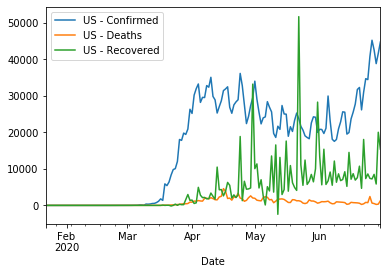

In [89]:
WORLD['US'].diff().plot()

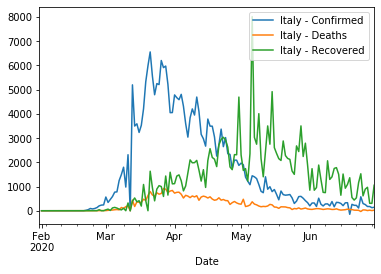

In [90]:
WORLD['Italy'].diff().plot()

In [26]:
corona.df.head()

,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


In [27]:
corona.df_us.head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered,state,Confirmed Per Capita,Deaths Per Capita,Recovered Per Capita
Date,,,,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-23,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-24,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-25,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-26,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0


In [28]:
md = corona.get_group_ts('MD')
md

,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


## Overall Stats to Calculate

- ?


In [29]:
# df = corona.df_us.copy()

# ## Report Total Cases
# total_cases = df.groupby('state').sum()[['Confirmed','Deaths']]
# total_cases.sort_values('Confirmed',0,0).head(20).style.bar(['Deaths','Confirmed'])

#  📕Covid Tracking Project Data

https://covidtracking.com/api

`/api/v1/states/{state}/screenshots.csv`

In [30]:
from fsds.imports import *

pd.set_option('display.max_columns',0)

### Get US Daily


In [31]:
import datetime as dt
import requests
import json,urllib
# todays_date = dt.datetime.now().strftime('%m%d%Y')

# base_url = f"http://covidtracking.com"
# # state='ny'
# # url = f"http://covidtracking.com/api/v1/states/{state}/screenshots.json"
# us_daily_url = '/api/v1/us/daily.csv'
# states_daily_url = '/api/v1/states/daily.csv'

## 📦 class `CovidTrackingProject`

In [32]:
from functions import CovidTrackingProject

In [34]:
covid=CovidTrackingProject(download=True,verbose=True)
covid

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"
states


------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	download_state_daily
	download_state_meta
	download_us_daily
	get_csv_save_load
	get_group_ts
	help

ATTRIBUTES
	base_folder
	base_url
	columns
	columns_us
	df
	df_states
	df_states_metadata
	df_us
	urls

In [37]:
covid.df_states

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,AK,1017.0,114892.0,NaN,18.0,NaN,NaN,NaN,1.0,NaN,535.0,A,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,14.0,NaN,2020-07-02T00:00:00Z,115909.0,NaN,NaN,NaN,2,39,1470,115909,115909,1509,115909,0,0,5ceb0f7088d68f2109723045dc01361a8be8f4aa,0,0,0,0,0,NaN
2020-07-02,AL,40111.0,379617.0,NaN,843.0,2835.0,NaN,826.0,NaN,468.0,22082.0,B,7/2/2020 11:00,2020-07-02T11:00:00Z,07/02 07:00,985.0,2835.0,2020-07-02T11:00:00Z,NaN,NaN,NaN,39604.0,1,1149,4626,419728,419728,5775,419728,13,32,bc01418e5a22f60d16bd176bbb53e937cef2dc5f,0,0,0,0,0,NaN
2020-07-02,AR,22075.0,301912.0,NaN,272.0,1477.0,NaN,NaN,72.0,231.0,15698.0,A,7/2/2020 14:46,2020-07-02T14:46:00Z,07/02 10:46,279.0,1477.0,2020-07-02T14:46:00Z,NaN,NaN,NaN,22075.0,5,878,8251,323987,323987,9129,323987,2,29,2413f6ff37227446a9c86921de099b46c163315f,0,0,0,0,0,NaN
2020-07-02,AS,0.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,6/27/2020 00:00,2020-06-27T00:00:00Z,06/26 20:00,0.0,NaN,2020-06-27T00:00:00Z,NaN,NaN,NaN,NaN,60,0,0,696,696,0,696,0,0,2f4ba1329beda94564e2d27052e2b97d2e3c99ca,0,0,0,0,0,NaN
2020-07-02,AZ,87425.0,473414.0,NaN,2938.0,4916.0,723.0,NaN,488.0,NaN,10137.0,A+,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,1757.0,4916.0,2020-07-02T00:00:00Z,560384.0,NaN,NaN,86970.0,4,3333,7910,560839,560839,11243,560839,37,79,4aaef59a1ee4088ad1086a7ac6f469b856ae402b,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,760c3dc0f1be8778f30b6d200547f3b5ac745758,0,0,0,0,0,NaN
2020-01-25,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,8c8515283dd7f193d5ec506f4d6ef8334bc50770,0,0,0,0,0,NaN
2020-01-24,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,01659896e63df6a3a877a4c826167fe0e44cb8a8,0,0,0,0,0,NaN


In [38]:
df_us = covid.df_us.copy()
# sorted(list(df_us.columns))
df_us.columns

Index(['states', 'positive', 'negative', 'pending', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dateChecked', 'death', 'hospitalized', 'lastModified', 'total',
       'totalTestResults', 'posNeg', 'deathIncrease', 'hospitalizedIncrease',
       'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease',
       'hash'],
      dtype='object')

In [ ]:
# df_us['fips']

In [41]:
good_us_cols = ['dateChecked','death', 'hash', 'hospitalizedCumulative',
 'hospitalizedCurrently','inIcuCumulative', 'inIcuCurrently',
 'negative', 'onVentilatorCumulative', 'onVentilatorCurrently',
 'pending','positive','recovered','states']

dep_us_cols = ['hospitalized', 'lastModified', 'total', 
             'totalTestResults', 'posNeg', 'deathIncrease',
            'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease', 
            'totalTestResultsIncrease']#[col for col in df_us.columns if col not in good_us_cols]
# print(dep_cols)

In [43]:
df = covid.df_us[covid.columns_us['good']].copy()
df[good_us_cols]

,dateChecked,death,hash,hospitalizedCumulative,hospitalizedCurrently,inIcuCumulative,inIcuCurrently,negative,onVentilatorCumulative,onVentilatorCurrently,pending,positive,recovered,states
date,,,,,,,,,,,,,,
2020-07-02,2020-07-02T00:00:00Z,121487.0,b4ecc6c883b4b7f5eefc00cd90a06d68d98b1d2e,245722.0,37114.0,10816.0,5609.0,30734553,1041.0,2105.0,2208.0,2727628,781970.0,56
2020-07-01,2020-07-01T00:00:00Z,120853.0,f2966df0f86a9c1441db7ec10133690a51db09b6,243846.0,35937.0,10752.0,5494.0,30152546,1027.0,2098.0,2604.0,2674813,729994.0,56
2020-06-30,2020-06-30T00:00:00Z,120152.0,480e9c7356c3b9278e1276e93eba16989d51c51f,242408.0,34830.0,10669.0,5406.0,29584414,1008.0,2044.0,2432.0,2621831,720631.0,56
2020-06-29,2020-06-29T00:00:00Z,119556.0,1e5c023acc5e3dc40dfb5c8dcb85625f801ccba3,240826.0,33198.0,10542.0,5363.0,28979934,990.0,2011.0,2194.0,2577473,705203.0,56
2020-06-28,2020-06-28T00:00:00Z,119226.0,5a80c658c8584c128e199ee1f6a823f452739257,240156.0,32117.0,10473.0,5230.0,28447030,983.0,2077.0,2198.0,2540983,685164.0,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,2020-01-26T00:00:00Z,NaN,e1cf59ab48e1cf367c4a6798a508a23d9d36bd18,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,NaN,1
2020-01-25,2020-01-25T00:00:00Z,NaN,bef2a1d5f2a13491e0e0369bbd46c10cdd12973b,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,NaN,1
2020-01-24,2020-01-24T00:00:00Z,NaN,bfffe76fc0b7cf11efe8aecd3cc7b22598d77d61,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,NaN,1


In [ ]:
covid

In [ ]:
covid.US

# APPENDIX

In [ ]:
## Load in Fips Data
fips = pd.read_csv('Reference Data/ZIP-COUNTY-FIPS_2018-03.csv')
fips.groupby('STATE').get_group("NY")['STCOUNTYFP'].value_counts()

In [ ]:
fips.loc[fips['STCOUNTYFP']==36]

In [ ]:

df = covid.STATES
df['fips']

In [ ]:
# #     def __init__(self):
# tracking = CovidTrackingProject()
# states_daily = tracking.download_state_daily()
# us_daily=tracking.download_us_daily()
# state_meta = tracking.download_state_meta()
# display(states_daily.head(),us_daily.head(),state_meta.head())

In [ ]:
covid = CovidTrackingProject(download=True)
state_meta = covid.data['states_metadata']
states_daily = covid.data['states']
state_list = state_meta['state'].unique()
states_daily

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
report  = ProfileReport(states_daily)


## NOTES: COLUMNS TO PLOT

- Basic Stats:
    - death: cumulative total people died
    - positive: total number people positive so far
    - negative
    - recovered
    

- Hospitalization:
    - hospitalizedCumulative: total number hospital so far(recovered and dead)
    - hospitalizedCurrently: 
    - hospitalizedIncrease


- ICU:
    - inIcuCumulative: total number hospital so far(recovered and dead)
    - inIcuCurrently: 
    
- Ventilator 
    - onVentilatorCumulative
    - onVentilatorCurrently


In [ ]:

covid.columns

In [ ]:
NY = states_daily.groupby('state').get_group('NY')[covid.columns['good']]
NY

# 🗺Adding Mapping

## Geocoding

In [ ]:
df = corona.df_us
df

In [ ]:
# !pip install geopandas
# !pip install geopy

In [ ]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")
res = locator.geocode('Baltimore')
res.latitude,res.longitude

## Folium

In [ ]:
# import folium
# center = (res.latitude,res.longitude) #(resp['region']['center']['latitude'],resp['region']['center']['longitude'])

# popup = folium.Popup(f"Latitude={center[0]}, Longitude={center[1]}")
# marker = folium.Marker(center,popup)
# mymap = folium.Map(center)
# marker.add_to(mymap)
# mymap